/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


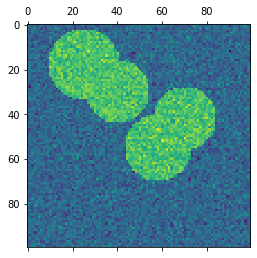

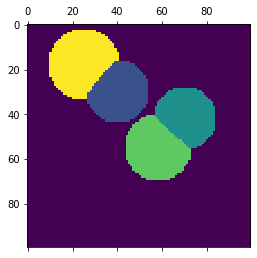

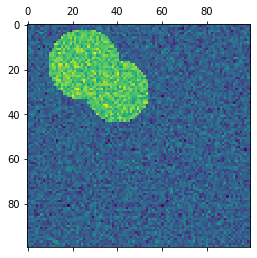

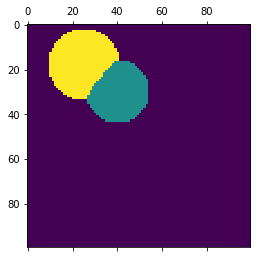

In [16]:
# Spectral clustering for image segmentation
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (18, 25)
center2 = (30, 40)
center3 = (55, 58)
center4 = (42, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

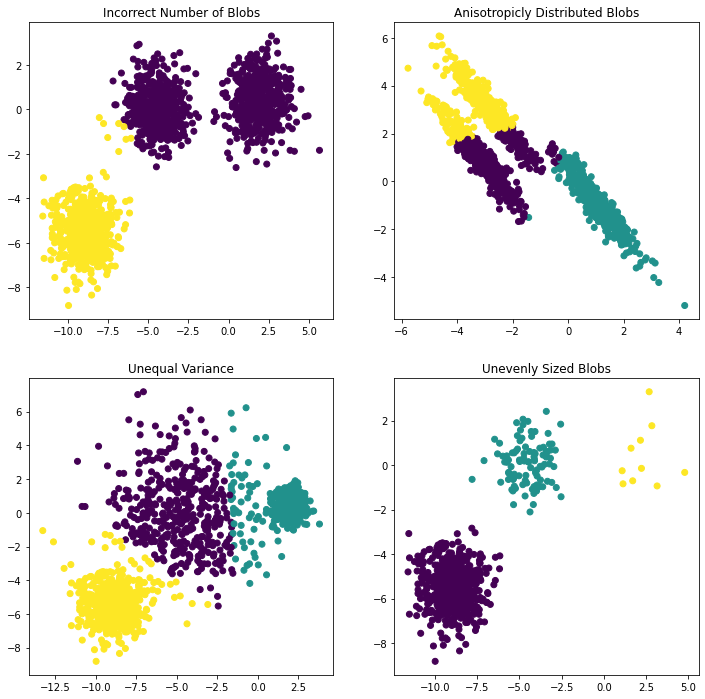

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

number of estimated clusters : 3


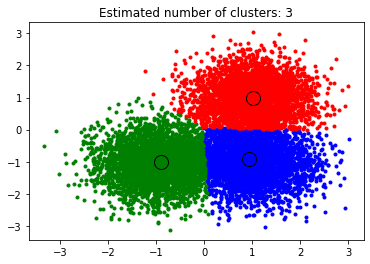

In [8]:
# A demo of the mean-shift clustering algorithm
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs


# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Computing embedding
Done.
ward :	0.37s
average :	0.27s
complete :	0.26s
single :	0.14s


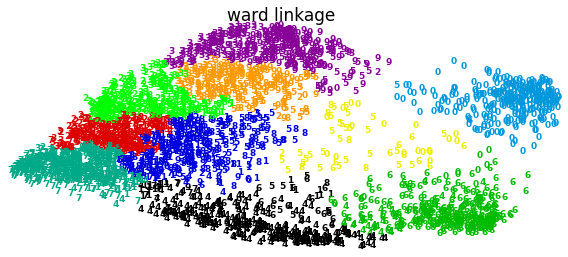

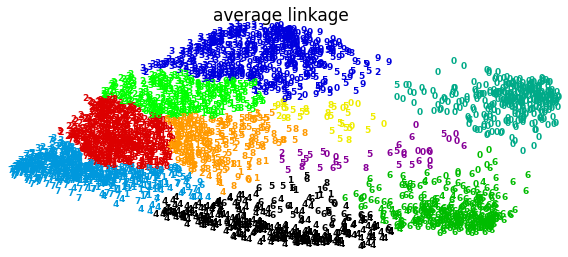

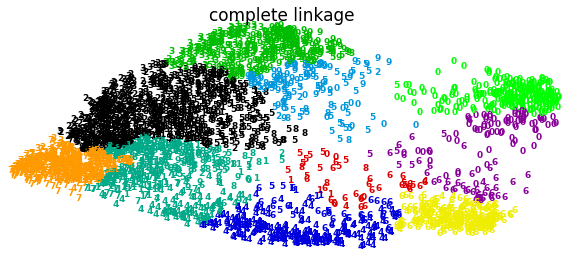

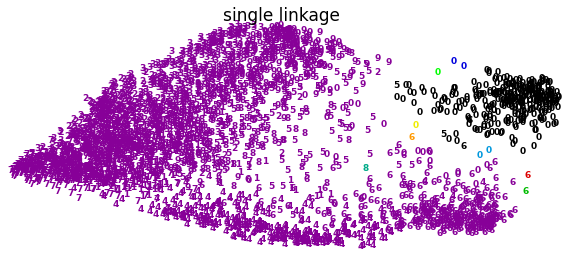

In [13]:
# Various Agglomerative Clustering on a 2D embedding of digits
from time import time

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

X, y = datasets.load_digits(return_X_y=True)
n_samples, n_features = X.shape

np.random.seed(0)


def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(
        x.reshape((8, 8)), 0.3 * np.random.normal(size=2), mode="constant"
    ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y

X, y = nudge_images(X, y)

# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 4))
    for i in range(X_red.shape[0]):
        plt.text(
            X_red[i, 0],
            X_red[i, 1],
            str(y[i]),
            color=plt.cm.nipy_spectral(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

Compute unstructured hierarchical clustering...
Elapsed time: 0.03s
Number of points: 1000
Compute structured hierarchical clustering...
Elapsed time: 0.94s
Number of points: 1000


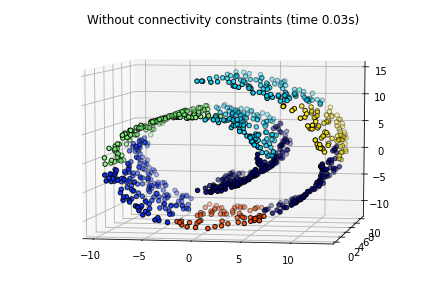

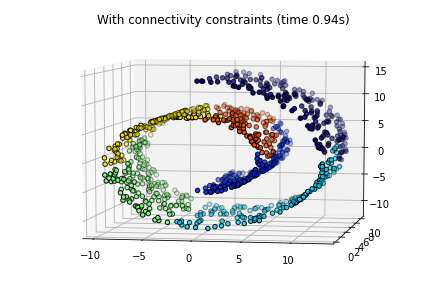

In [15]:
# Hierarchical clustering: structured vs unstructured ward
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

# #############################################################################
# Generate data (swiss roll dataset)
n_samples = 1000
noise = 0.025
X, _ = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= 0.5

# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage="ward").fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
plt.title("Without connectivity constraints (time %.2fs)" % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(
    n_clusters=6, connectivity=connectivity, linkage="ward"
).fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
plt.title("With connectivity constraints (time %.2fs)" % elapsed_time)

plt.show()

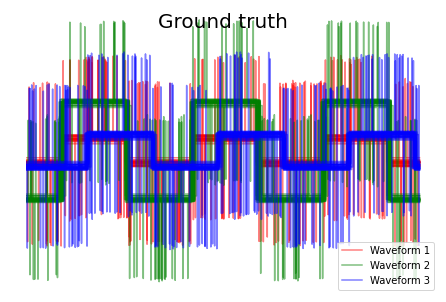

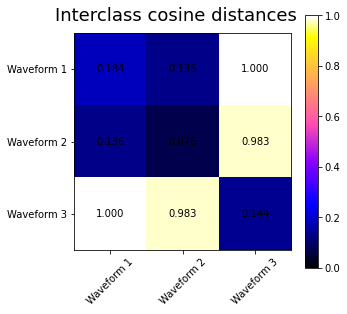

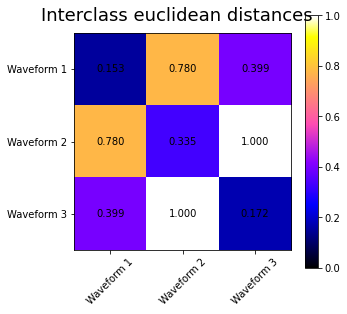

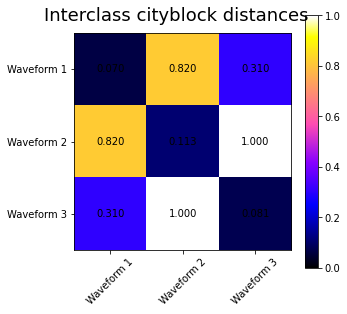

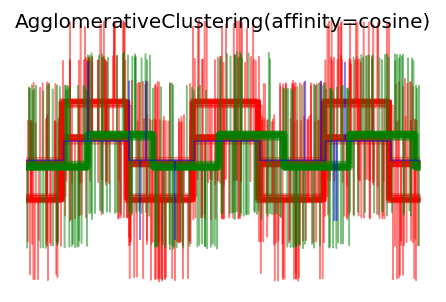

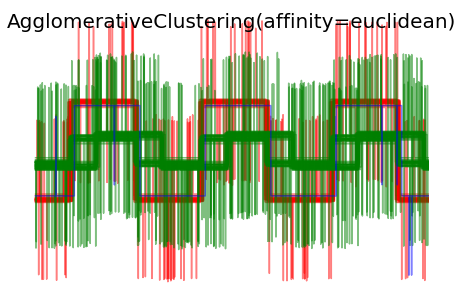

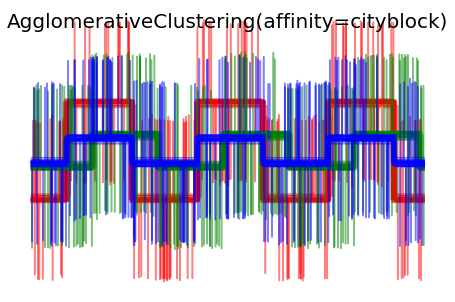

In [19]:
# Agglomerative clustering with different metrics
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2500
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))


X = list()
y = list()
for i, (phi, a) in enumerate([(0.5, 0.15), (0.5, 0.6), (0.3, 0.2)]):
    for _ in range(30):
        phase_noise = 0.01 * np.random.normal()
        amplitude_noise = 0.025 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < 0.997] = 0

        X.append(
            12
            * (
                (a + amplitude_noise) * (sqr(6 * (t + phi + phase_noise)))
                + additional_noise
            )
        )
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ("Waveform 1", "Waveform 2", "Waveform 3")

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), "rgb", labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=0.5)
    lines[0].set_label(n)

plt.legend(loc="best")

plt.axis("tight")
plt.axis("off")
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y == i], X[y == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(
                i,
                j,
                "%5.3f" % avg_dist[i, j],
                verticalalignment="center",
                horizontalalignment="center",
            )

    plt.imshow(avg_dist, interpolation="nearest", cmap=plt.cm.gnuplot2, vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average", affinity=metric
    )
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), "rgbk"):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=0.5)
    plt.axis("tight")
    plt.axis("off")
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


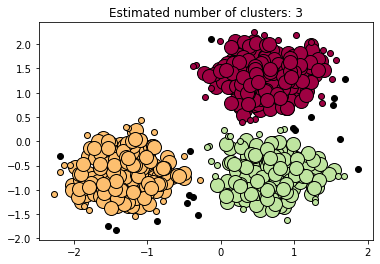

In [20]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Computing adjusted_rand_score for 10 values of n_clusters and n_samples=100
done in 0.054s
Computing v_measure_score for 10 values of n_clusters and n_samples=100
done in 0.060s
Computing ami_score for 10 values of n_clusters and n_samples=100
done in 0.438s
Computing mutual_info_score for 10 values of n_clusters and n_samples=100
done in 0.051s
Computing adjusted_rand_score for 10 values of n_clusters and n_samples=1000
done in 0.062s
Computing v_measure_score for 10 values of n_clusters and n_samples=1000
done in 0.084s
Computing ami_score for 10 values of n_clusters and n_samples=1000
done in 0.303s
Computing mutual_info_score for 10 values of n_clusters and n_samples=1000
done in 0.067s


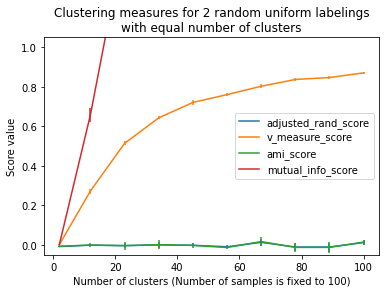

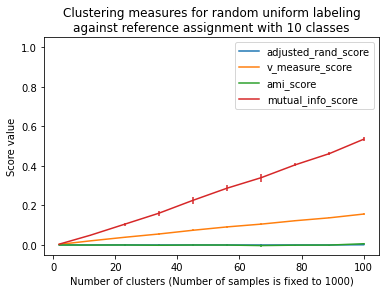

In [21]:
# Adjustment for chance in clustering performance evaluation
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics


def uniform_labelings_scores(
    score_func, n_samples, n_clusters_range, fixed_n_classes=None, n_runs=5, seed=42
):
    """Compute score for 2 random uniform cluster labelings.

    Both random labelings have the same number of clusters for each value
    possible value in ``n_clusters_range``.

    When fixed_n_classes is not None the first labeling is considered a ground
    truth class assignment with fixed number of classes.
    """
    random_labels = np.random.RandomState(seed).randint
    scores = np.zeros((len(n_clusters_range), n_runs))

    if fixed_n_classes is not None:
        labels_a = random_labels(low=0, high=fixed_n_classes, size=n_samples)

    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            if fixed_n_classes is None:
                labels_a = random_labels(low=0, high=k, size=n_samples)
            labels_b = random_labels(low=0, high=k, size=n_samples)
            scores[i, j] = score_func(labels_a, labels_b)
    return scores


def ami_score(U, V):
    return metrics.adjusted_mutual_info_score(U, V)


score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    ami_score,
    metrics.mutual_info_score,
]

# 2 independent random clusterings with equal cluster number

n_samples = 100
n_clusters_range = np.linspace(2, n_samples, 10).astype(int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print(
        "Computing %s for %d values of n_clusters and n_samples=%d"
        % (score_func.__name__, len(n_clusters_range), n_samples)
    )

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range)
    print("done in %0.3fs" % (time() - t0))
    plots.append(
        plt.errorbar(n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0]
    )
    names.append(score_func.__name__)

plt.title(
    "Clustering measures for 2 random uniform labelings\nwith equal number of clusters"
)
plt.xlabel("Number of clusters (Number of samples is fixed to %d)" % n_samples)
plt.ylabel("Score value")
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)


# Random labeling with varying n_clusters against ground class labels
# with fixed number of clusters

n_samples = 1000
n_clusters_range = np.linspace(2, 100, 10).astype(int)
n_classes = 10

plt.figure(2)

plots = []
names = []
for score_func in score_funcs:
    print(
        "Computing %s for %d values of n_clusters and n_samples=%d"
        % (score_func.__name__, len(n_clusters_range), n_samples)
    )

    t0 = time()
    scores = uniform_labelings_scores(
        score_func, n_samples, n_clusters_range, fixed_n_classes=n_classes
    )
    print("done in %0.3fs" % (time() - t0))
    plots.append(
        plt.errorbar(n_clusters_range, scores.mean(axis=1), scores.std(axis=1))[0]
    )
    names.append(score_func.__name__)

plt.title(
    "Clustering measures for random uniform labeling\n"
    "against reference assignment with %d classes" % n_classes
)
plt.xlabel("Number of clusters (Number of samples is fixed to %d)" % n_samples)
plt.ylabel("Score value")
plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names)
plt.show()